# C1 - Introduction to Human and Computer Vision
## Week 2 - Draft Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import matplotlib.pyplot as plt

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week2')
os.chdir(BASE_PATH)
BASE_PATH

'/projects/master/c1/Team5/week2'

### Load datasets

In [3]:
from src.image_dataset import ImageDataset, ColorSpace
from src.consts import DescriptorType

DATA_DIRECTORY = '../data'

params = {
    'colorspace': ColorSpace.CieLab,
    'intervals': [7, 7, 7],
    'rows': 7,
    'columns': 7,
    'channels': [[0], [1], [2]]
}

BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', DescriptorType.Block, params)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', DescriptorType.Block, params)

### Task 1 - Block and hierarchical histograms

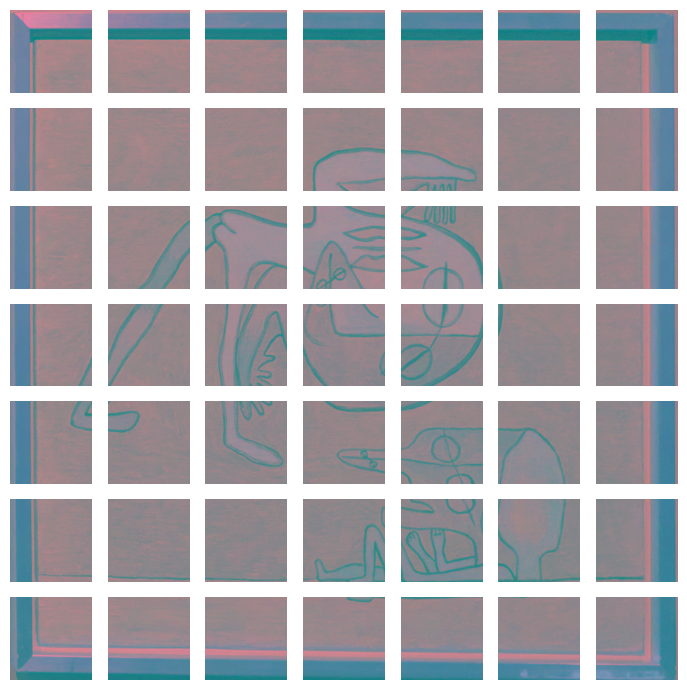

In [4]:

image = QueryDataset[0]

# ----- Plot the Image Blocks -----
fig, axes = plt.subplots(params['rows'], params['columns'], figsize=(params['columns'], params['rows']))
    
for i in range(params['rows']):
    for j in range(params['columns']):
        axes[i, j].imshow(image.descriptors.blocks[i][j])
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

In [5]:
len(image.descriptors), len(image.descriptors[0]), image.descriptors[0][0].shape

(7, 7, (108,))

Notice how:

255 // 10 intervals = 25 bins and

25 bins*3 image channels = 75 concatenated color channels for each block

#### Spatial Pyramid Representation

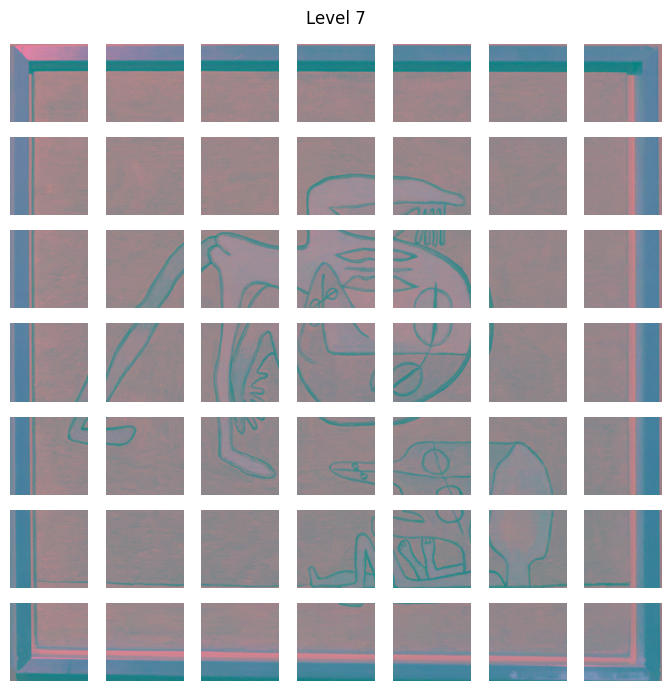

In [6]:
# Let's start by square grids

# The level indicates the size of the grid used to divide the image by block. For example, level 4 indicates we divide the image with a grid of 4x4 blocks
levels = [7]

for level in levels:
    ROWS = level
    COLUMNS = level

    # Update histogram_descriptor
    image.descriptors.compute_image_histogram_descriptor(intervals=params['intervals'], rows=ROWS, columns=COLUMNS)

    # ----- Plot the Image Blocks -----
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(COLUMNS, ROWS))
        
    for i in range(ROWS):
        for j in range(COLUMNS):
            axes[i, j].imshow(image.descriptors.blocks[i][j])
            axes[i, j].axis('off') 

    plt.suptitle(f'Level {level}')
    plt.tight_layout(w_pad=0.1)
    plt.show()



### Task 2 - Evaluate retrieval results

#### Block-based Histograms

In [7]:
import pickle

# Get ground truth
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

In [8]:
from src.evaluation import compute_results_by_similarity, compute_results_by_distance
from src.metrics import SimilarityType, DistanceType
import numpy as np

metric = DistanceType.l1

res = compute_results_by_distance(
    BDDataset, QueryDataset, ground_truth, metric,
)

result = {}
result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

{'l1_distance': {'mapk1': np.float64(0.8666666666666667), 'mapk5': np.float64(0.9)}}


#### Spatial Pyramid Representation

In [9]:
import importlib
from src.metrics import DistanceType
from src.evaluation import compute_result_list_similarity, compute_result_list_distance

levels = [7]

res = {}

metric = DistanceType.l1

for level in levels:    
    for image in BDDataset.images:
        image.descriptors.compute_image_histogram_descriptor(params['intervals'], level, level)
    
    for image in QueryDataset.images:
        image.descriptors.compute_image_histogram_descriptor(params['intervals'], level, level)
    
    res_i = compute_result_list_distance(
        BDDataset, QueryDataset, metric,
    )

    res[level] = res_i

In [10]:
final_result = []
for i in range(len(QueryDataset)):
    prediction_levels = [res[level][i] for level in levels]
    final_result.append([(tup[0][0], min(tup[i][1] for i in range(len(tup)))) for tup in zip(*prediction_levels)])

In [11]:
if metric == DistanceType.l1:
    sorting_key = lambda x: x[1]
else:
    sorting_key = lambda x: -x[1]

for i in range(len(final_result)):
    final_result[i] = sorted(final_result[i], key=sorting_key)

top10s = [[x[i][0] for i in range(10)] for x in final_result]

In [12]:
from src.metrics import mapk

print('APK1: ', mapk(ground_truth, top10s, k=1))
print('APK5: ', mapk(ground_truth, top10s, k=5))

APK1:  0.8666666666666667
APK5:  0.9


### Task 3 - Background removal

In [13]:
BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd2_w2', DescriptorType.Block, params)

#### Plot Original / Groundtruth / Obtained Mask

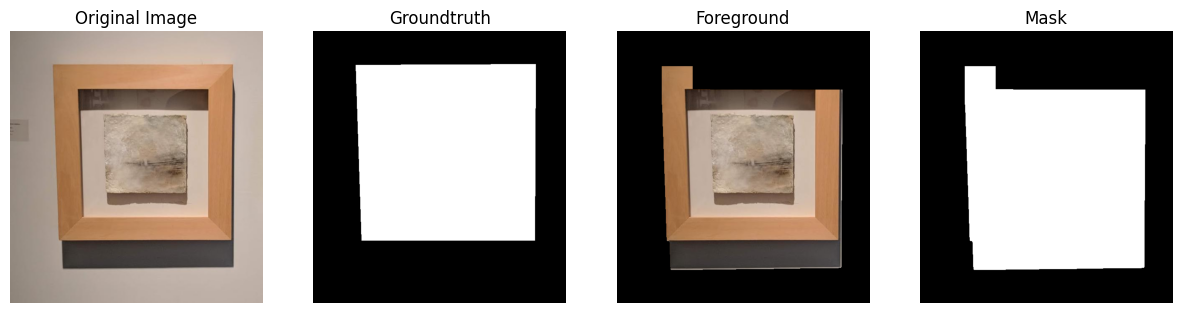

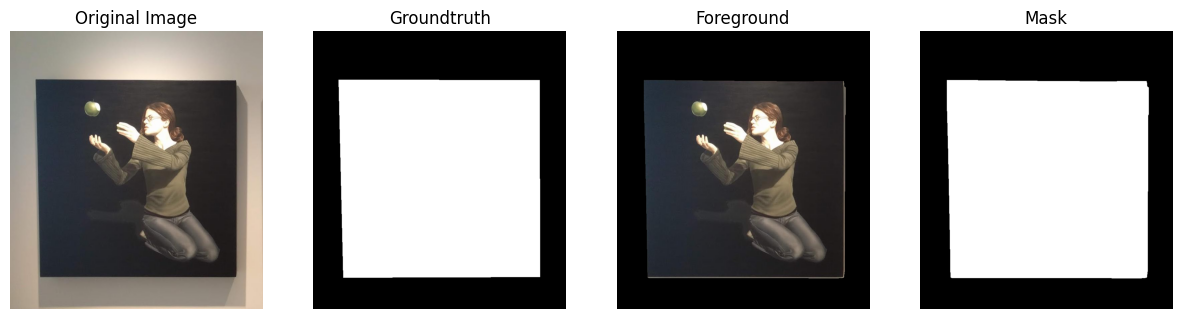

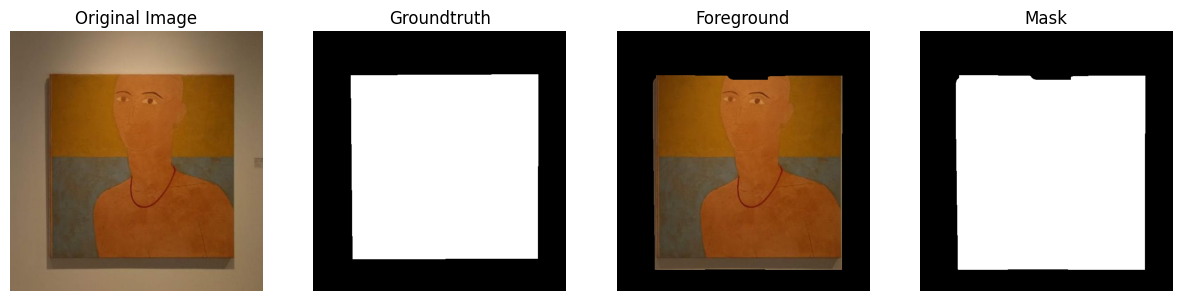

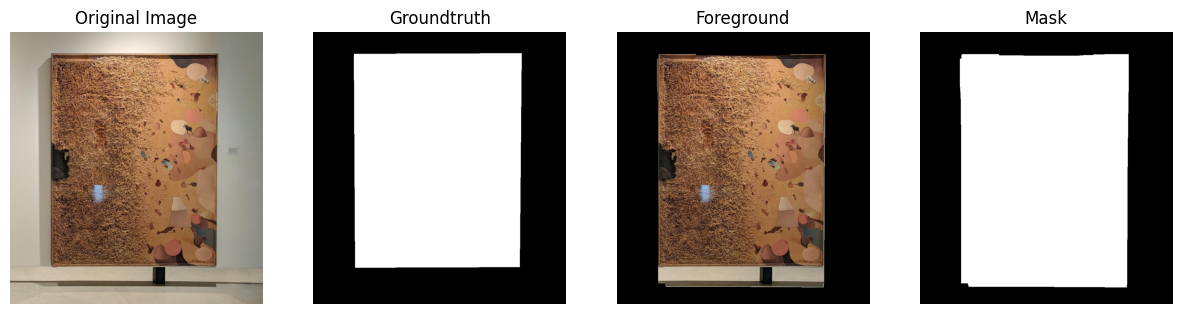

In [14]:
import importlib
import cv2
import src.background_removal


from src.background_removal import get_mask_and_foreground

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w2') if f.endswith('.png')]
background_files = sorted(background_files, key=lambda x: int(re.findall(r'\d+', x)[0]))

# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
for i in range(0, 4):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd2_w2', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Get foreground and mask
    foreground, mask = get_mask_and_foreground(image)
    plt.subplot(1, 4, 3)
    plt.imshow(foreground)
    plt.title('Foreground')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

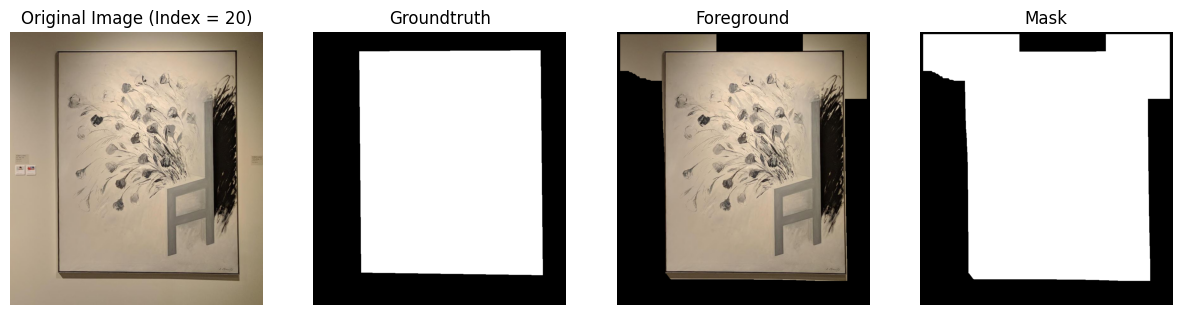

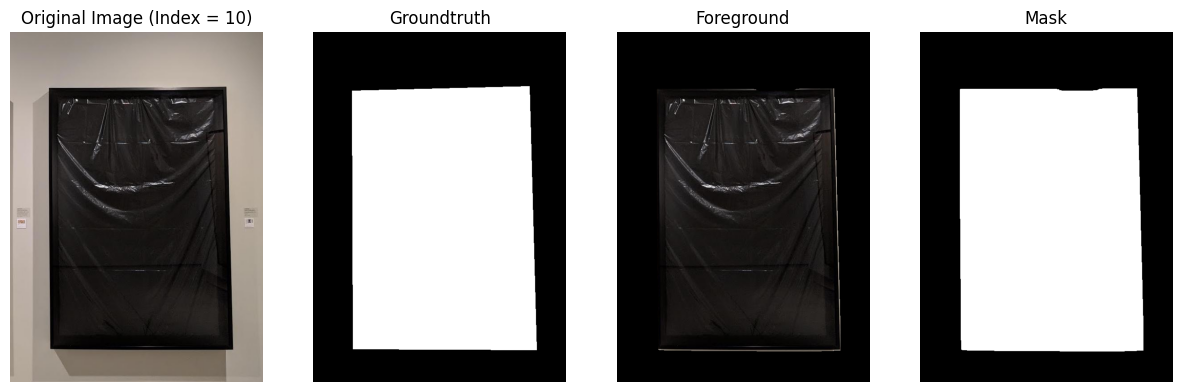

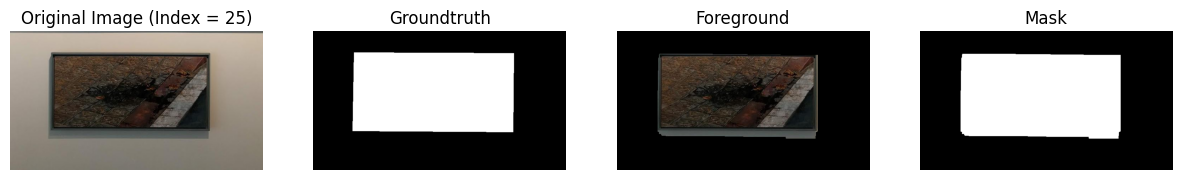

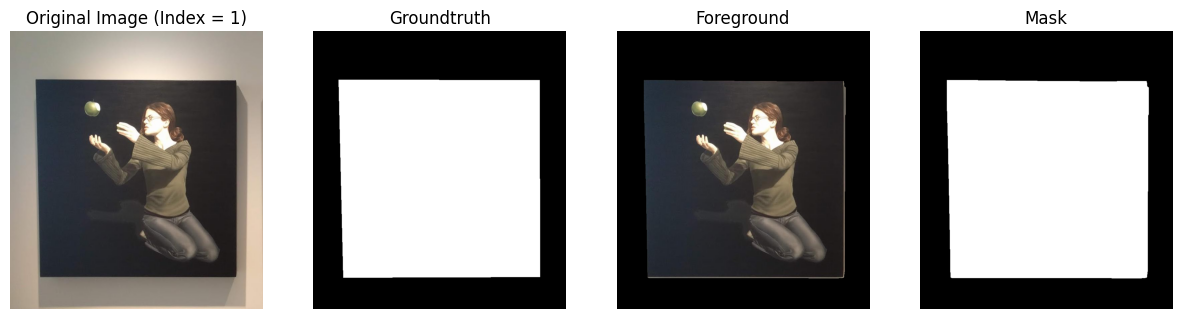

In [15]:
import importlib
import cv2
import src.background_removal


from src.background_removal import get_mask_and_foreground
import random

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w2') if f.endswith('.png')]
background_files = sorted(background_files, key=lambda x: int(re.findall(r'\d+', x)[0]))

# Sample 4 images at random without repetition
image_list = random.sample(range(len(background_files)), 4)

# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
for i in image_list:
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title(f'Original Image (Index = {i})')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd2_w2', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Get foreground and mask
    foreground, mask = get_mask_and_foreground(image)
    plt.subplot(1, 4, 3)
    plt.imshow(foreground)
    plt.title('Foreground')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

In [16]:
mask, foreground = get_mask_and_foreground(image)

#### Save masks

In [17]:
FOREGROUND_DIR = "data_results/foregrounds"
MASK_DIR = "data_results/masks"

In [18]:
for path in [FOREGROUND_DIR, MASK_DIR]:
    if not os.path.exists(path):
        os.makedirs(path)

def get_image_filename(path):
    """
    Returns image filename (e.g. 00000, 00001, ...)
    """
    base_name = os.path.basename(path)
    file_name = os.path.splitext(base_name)[0]
    return file_name

# Save Foreground and Masks results
for i in range(0, len(background_files)):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)
    filename = get_image_filename(BGDataset.images[i].path)

    # Get the foreground and mask
    foreground, mask = get_mask_and_foreground(image)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, f"{filename}.png")
    mask_path = os.path.join(MASK_DIR, f"{filename}.png")

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

### Task 4 - Masks evaluation

In [19]:
import pandas as pd
import src.background_removal

# Reload after making changes
importlib.reload(src.background_removal)
from src.background_removal import evaluate_masks

# First directory needs to be updated!
precision, recall, f1_score = evaluate_masks(f'{MASK_DIR}', f'{DATA_DIRECTORY}/qsd2_w2')

results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [precision, recall, f1_score]
})
print(results)

      Metric     Value
0  Precision  0.911154
1     Recall  0.936273
2   F1 Score  0.914322


### Task 5 - Retrieval

In [20]:
image = BGDataset[0]
_, mask = get_mask_and_foreground(image.descriptors.original_image)
mask.shape

(650, 605)

In [21]:
from src.background_removal import get_mask_and_foreground
import cv2

for image in BDDataset:
    _, mask = get_mask_and_foreground(image.descriptors.original_image)
    # Averiguar como pasar la puta mascara
    image.descriptors.compute_image_histogram_descriptor(
        params['intervals'],
        params['rows'],
        params['columns'],
        params['channels'],
        mask
        )


In [22]:

for image in BGDataset:
    _, mask = get_mask_and_foreground(image.descriptors.original_image)
    image.descriptors.compute_image_histogram_descriptor(
        params['intervals'],
        params['rows'],
        params['columns'],
        params['channels'],
        mask=mask)

In [23]:
metric = DistanceType.l1

with open(f'{DATA_DIRECTORY}/qsd2_w2/gt_corresps.pkl', 'rb') as f:
    ground_truth_qsd2_w2 = pickle.load(f)

res = compute_results_by_distance(
    BDDataset, BGDataset, ground_truth_qsd2_w2, metric,
)

result = {}
result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

{'l1_distance': {'mapk1': np.float64(0.3), 'mapk5': np.float64(0.3427777777777778)}}


### Task 6 - .pkl results generation